In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

In [3]:
table = pd.read_csv('../data/main_table_221115.csv')

C:\Users\richa\AppData\Local\Temp\ipykernel_22856\1687289751.py:1: DtypeWarning: Columns (60) have mixed types. Specify dtype option on import or set low_memory=False.
  table = pd.read_csv('../data/main_table_221115.csv')


In [4]:
df_array = []

t = pd.read_csv('../data/gwas_hits_5e-08.csv')
t['type'] = 'gwas'
df_array.append(t)

t = pd.read_csv('../data/aff_ms_hits.csv')
t['type'] = 'aff_ms'
df_array.append(t)

t = pd.read_csv('../data/transcriptomics_hits_0.05.csv')
t['type'] = 'transcriptomics'
df_array.append(t)

t = pd.read_csv('../data/crispr_hits.csv')
t['type'] = 'crispr'
df_array.append(t)

hits_df = pd.concat(df_array).reset_index(drop=True)

In [4]:
hits_df.to_csv('../data/combined_hits.csv', index=False)

In [5]:
hit_dict = hits_df.groupby(['type', 'set'])['gene_ncbi'].apply(set).to_dict()

Binary table

In [7]:
binary_props = ['mouse_pheno', 'mendelian_inheritance', 'mouse', 'rat',
       'c_elegans', 'd_melanogaster', 'yeast', 'zebrafish', 'primate_specific',
       'nextprot_evidence', 'hpa_evidence', 'uniprot_evidence',
       'membrane_protein', 'antibody', 'approved_ih', 'approved_if',
       'idg_understudied', 'plasmid', 'compound', 'previously_patented',
               'loss_of_function_intolerant', 'druggable']

In [8]:
%%time
alpha = 0.05
crit = scipy.stats.norm.ppf(1-(alpha/2))
result_array = []
for exp_type in ['gwas', 'crispr', 'transcriptomics', 'aff_ms']:
    hits = hit_dict.get((exp_type, 'hits'))
    mentioned_hits = hit_dict.get((exp_type, 'mentioned_hits'))
    non_mentioned_hits = hits - mentioned_hits

    table_slice = table[table['gene_ncbi'].isin(hits)].copy()
    table_slice['mentioned'] = table_slice['gene_ncbi'].isin(mentioned_hits)

    for prop in binary_props:
        cont_table = (
        table_slice.groupby(['mentioned', prop])
        .count()
        .reset_index()
        .pivot(index='mentioned', columns=prop, values='gene_ncbi')
        .fillna(0.0)
        )

        odds_ratio, p = scipy.stats.fisher_exact(cont_table.values)
        
        a,b,c,d = cont_table.values.flatten()
        low = np.exp(np.log(odds_ratio) - crit*np.sqrt((1/a) + (1/b) + (1/c) + (1/d)))
        upp = np.exp(np.log(odds_ratio) + crit*np.sqrt((1/a) + (1/b) + (1/c) + (1/d)))
        
        result = pd.DataFrame({'type':[exp_type], 
                               'property':[prop], 
                               'odds_ratio':[odds_ratio], 
                               'lb':[low],
                               'ub':[upp],
                               'p':[p]})
        result_array.append(result)
        
result_df = pd.concat(result_array).reset_index(drop=True)

<timed exec>:24: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:24: RuntimeWarning: invalid value encountered in double_scalars
<timed exec>:25: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:24: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:24: RuntimeWarning: invalid value encountered in double_scalars
<timed exec>:25: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:24: RuntimeWarning: divide by zero encountered in log
<timed exec>:24: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:25: RuntimeWarning: divide by zero encountered in log
<timed exec>:25: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:25: RuntimeWarning: invalid value encountered in double_scalars
<timed exec>:24: RuntimeWarning: divide by zero encountered in log
<timed exec>:24: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:25: Runti

CPU times: total: 26.1 s
Wall time: 26.1 s


In [9]:
result_df

,type,property,odds_ratio,lb,ub,p
0,gwas,mouse_pheno,1.242,0.961,1.606,1.110e-01
1,gwas,mendelian_inheritance,2.098,1.659,2.652,5.895e-10
2,gwas,mouse,0.845,0.547,1.303,4.986e-01
3,gwas,rat,0.978,0.661,1.446,9.205e-01
4,gwas,c_elegans,0.773,0.561,1.065,1.315e-01
...,...,...,...,...,...,...
83,aff_ms,plasmid,2.816,2.316,3.423,1.043e-27
84,aff_ms,compound,2.400,2.009,2.867,2.155e-21
85,aff_ms,previously_patented,1.437,1.202,1.718,7.099e-05
86,aff_ms,loss_of_function_intolerant,2.358,1.960,2.837,7.349e-19


In [10]:
asterisks = []
for p in result_df['p']:
    asterisk = ''
    if p < 0.05:
        asterisk = asterisk + '*'
    if p < 0.01:
        asterisk = asterisk + '*'
    if p < 0.001:
        asterisk = asterisk + '*'
    asterisks.append(asterisk)
    
result_df['asterisks'] = asterisks

In [11]:
result_df['text'] = result_df['odds_ratio'].round(3).astype(str) + result_df['asterisks'] + \
' (' + result_df['lb'].round(3).astype(str) + ', ' + \
+ result_df['ub'].round(3).astype(str) +')'

In [30]:
#result_df['text'] = result_df['odds_ratio'].round(3).astype(str) + result_df['asterisks']
result_df.to_csv('../data/binary_table_eval_221115.csv', index=False)

In [31]:
result_pivot = result_df.pivot(index='property', columns='type', values='text')
result_pivot.to_csv('../data/binary_table_eval_format_221115.csv')

In [37]:
result_pivot

type,aff_ms,crispr,gwas,transcriptomics
property,,,,
antibody,"2.656** (1.363, 5.176)","1.171 (0.277, 4.954)","1.057 (0.702, 1.591)","1.982** (1.211, 3.244)"
approved_if,"2.177*** (1.662, 2.852)","1.214 (0.513, 2.874)","0.849 (0.667, 1.082)","2.44*** (1.808, 3.295)"
approved_ih,"1.554*** (1.256, 1.924)","1.791 (0.757, 4.241)","1.184 (0.929, 1.508)","1.979*** (1.519, 2.578)"
c_elegans,"0.91 (0.74, 1.119)","1.868 (0.838, 4.165)","0.773 (0.561, 1.065)","0.923 (0.67, 1.273)"
compound,"2.4*** (2.009, 2.867)","2.617* (1.228, 5.574)","1.764*** (1.396, 2.23)","5.114*** (4.014, 6.516)"
d_melanogaster,"1.031 (0.856, 1.242)","2.033 (0.951, 4.349)","0.722* (0.54, 0.966)","0.842 (0.627, 1.13)"
druggable,"1.438*** (1.17, 1.767)","2.261 (1.034, 4.946)","2.132*** (1.682, 2.701)","3.37*** (2.663, 4.266)"
hpa_evidence,"2.237*** (1.754, 2.851)","1.638 (0.692, 3.878)","1.46** (1.139, 1.871)","2.54*** (1.913, 3.371)"
idg_understudied,"0.162* (0.023, 1.164)","2.739 (0.369, 20.324)","0.925 (0.345, 2.481)","0.0* (0.0, nan)"


Continuous table eval

In [12]:
continuous_props = \
['n_pubs', 'n_synonyms', 'n_gwas', 'n_biocarta', 'n_reactome',
       'n_hpo', 'n_wikipathways', 'n_pid', 'n_kegg', 'n_go', 
 'p_de', 'normalized_gravy', 
 'gene_length', 'detectable_portion', 'tissue_median', 'hela_expression',
'n_mouse_pubs', 'n_rat_pubs', 'n_d_melanogaster_pubs', 
 'n_zebrafish_pubs', 'n_c_elegans_pubs','n_yeast_pubs']

In [13]:
%%time

result_array = []
for exp_type in ['gwas', 'crispr', 'transcriptomics', 'aff_ms']:
    hits = hit_dict.get((exp_type, 'hits'))
    mentioned_hits = hit_dict.get((exp_type, 'mentioned_hits'))
    non_mentioned_hits = hits - mentioned_hits

    table_slice = table[table['gene_ncbi'].isin(hits)].copy()
    table_slice['mentioned'] = table_slice['gene_ncbi'].isin(mentioned_hits)

    for prop in continuous_props:
        prop_dict = table_slice.dropna(subset=[prop]).groupby('mentioned')[prop].apply(list).to_dict()
        a = np.array(prop_dict.get(False))
        b = np.array(prop_dict.get(True))
        
        u, p = scipy.stats.mannwhitneyu(b, a, alternative='two-sided')
        result = pd.DataFrame({'type':[exp_type], 
                               'property':[prop], 
                               'n_unmentioned':[len(a)], 
                               'n_mentioned':[len(b)],
                               'u':[u],
                               'p':[p]})
        result_array.append(result)
        
result_df = pd.concat(result_array).reset_index(drop=True)

CPU times: total: 625 ms
Wall time: 625 ms


In [14]:
result_df['f'] = result_df['u']/(result_df['n_unmentioned']*result_df['n_mentioned'])

In [15]:
asterisks = []
for p in result_df['p']:
    asterisk = ''
    if p < 0.05:
        asterisk = asterisk + '*'
    if p < 0.01:
        asterisk = asterisk + '*'
    if p < 0.001:
        asterisk = asterisk + '*'
    asterisks.append(asterisk)
    
result_df['asterisks'] = asterisks

In [16]:
result_df['text'] = result_df['f'].round(3).astype(str) + result_df['asterisks']
result_df.to_csv('../data/continuous_table_eval_221115.csv', index=False)

In [17]:
result_pivot = result_df.pivot(index='property', columns='type', values='text')
result_pivot.to_csv('../data/continuous_table_eval_format_221115.csv')

In [18]:
result_pivot

type,aff_ms,crispr,gwas,transcriptomics
property,,,,
detectable_portion,0.551***,0.588,0.439***,0.563***
gene_length,0.53*,0.572,0.556***,0.525
hela_expression,0.603***,0.552,0.432***,0.553**
n_biocarta,0.575***,0.601***,0.539***,0.669***
n_c_elegans_pubs,0.596***,0.722**,0.48,0.63***
n_d_melanogaster_pubs,0.64***,0.786***,0.542,0.782***
n_go,0.695***,0.711***,0.622***,0.806***
n_gwas,0.551***,0.584,0.633***,0.632***
n_hpo,0.579***,0.597*,0.605***,0.632***


In [16]:
table_slice = table[table['protein_coding']][continuous_props].rank(axis=0, 
                                                              pct=True, 
                                                              method='min', 
                                                              na_option='top').join(
        table[table['protein_coding']][binary_props].fillna(False)).join(
    table['symbol_from_nomenclature_authority'])
table_slice = table_slice.set_index('symbol_from_nomenclature_authority')

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


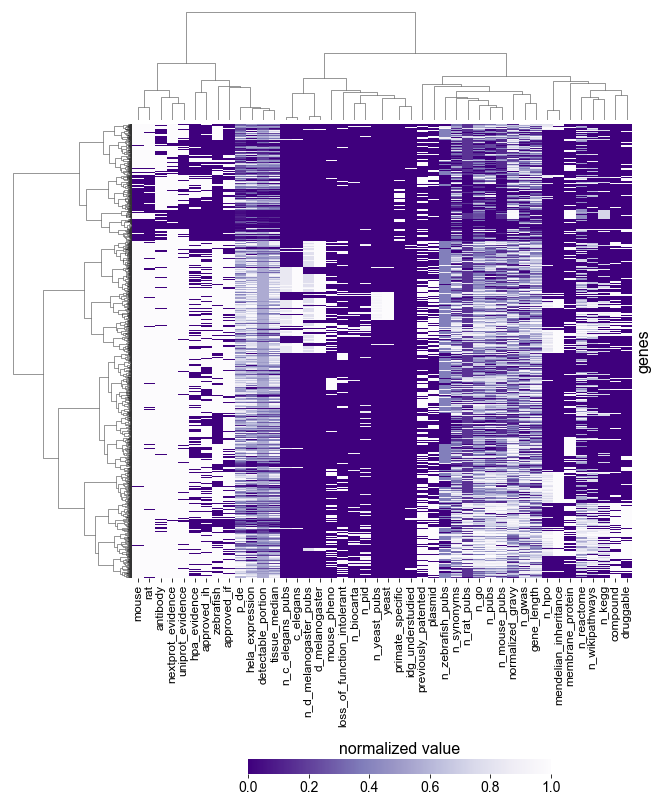

In [21]:
g = sns.clustermap(table_slice.dropna().astype(float), 
                   method='ward', 
                   cmap='Purples_r',
                   xticklabels=1, yticklabels=1000, figsize=(10,10),  
                   cbar_kws={'orientation':'horizontal'})
g.ax_heatmap.set_ylabel(None)
g.ax_cbar.set_position((0.35, -0.08, 0.42, 0.02))
g.ax_cbar.set_title(r'normalized value', fontsize=16)
g.ax_cbar.tick_params(labelsize=14)
g.ax_heatmap.tick_params(labelsize=12, axis='both')
g.ax_heatmap.tick_params(right=False, labelright=False, axis='y')
g.ax_heatmap.set_ylabel('genes', fontsize=16)

plt.savefig('../img/property_clustering_binary_rank_221117.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/property_clustering_binary_rank_221117.pdf', bbox_inches='tight')

export.image('general', p='figures/property_clustering_binary_rank.pdf', date=True)
export.raster_image('general', p='figures/property_clustering_binary_rank.png', date=True, dpi=600)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


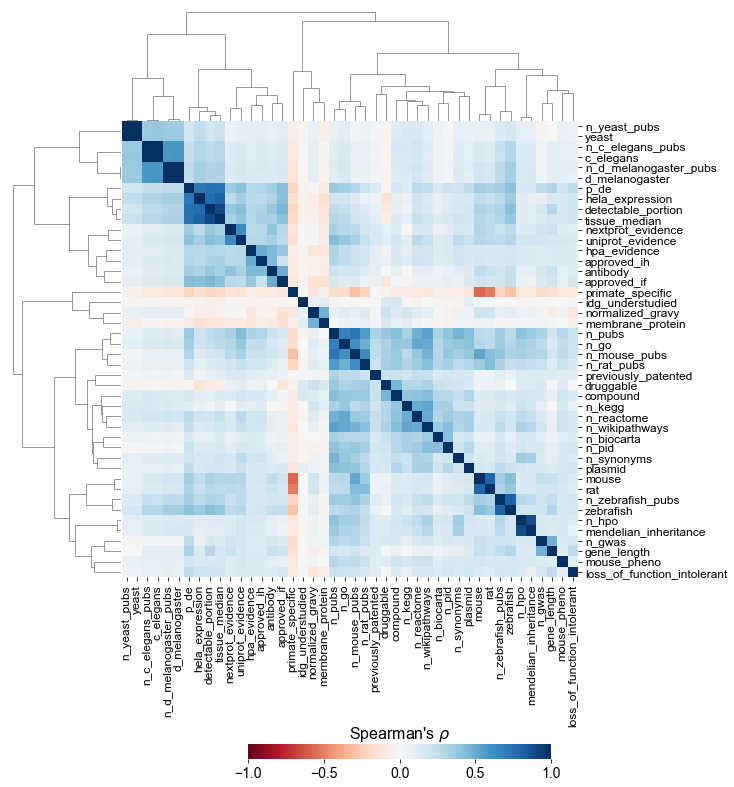

In [27]:
g = sns.clustermap(table_slice.corr(),
                   method='ward', 
                   cmap='RdBu',
                   xticklabels=1, 
                   yticklabels=1,
                   figsize=(10,10), vmin=-1, vmax=1, 
                   cbar_kws={'orientation':'horizontal'})

g.ax_cbar.set_position((0.35, -0.06, 0.42, 0.02))
g.ax_cbar.set_title(r"Spearman's $\rho$", fontsize=16)
g.ax_cbar.tick_params(labelsize=14)
g.ax_heatmap.tick_params(bottom=True, labelsize=12, axis='x')
g.ax_heatmap.tick_params(bottom=False, labelsize=12, axis='y', labelrotation=0)

plt.savefig('../img/property_clustering_matrix_221117.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/property_clustering_matrix_221117.pdf', bbox_inches='tight')

export.image('general', p='figures/property_clustering_matrix.pdf', date=True)
export.raster_image('general', p='figures/property_clustering_matrix.png', date=True, dpi=600)